<a href="https://colab.research.google.com/github/Mounavanam/cs666student/blob/main/Copy_of_CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

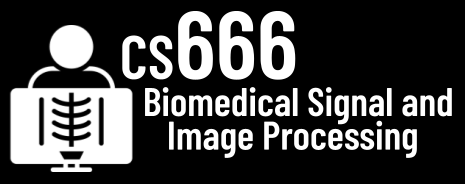
# Assignment 6

In [ ]:
# NAME: MOUNA VANAM

In [ ]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [ ]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-23 21:51:52--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.1’

mito.npz.1          100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-23 21:51:53 (316 MB/s) - ‘mito.npz.1’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [ ]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

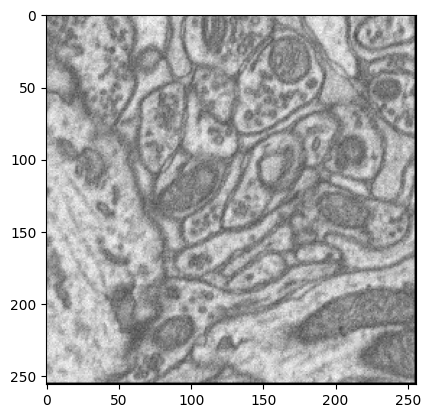

In [ ]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
plt.imshow(images[0],cmap='gray')
plt.show()

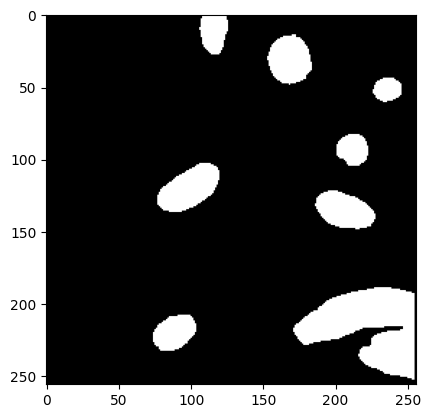

In [ ]:
# TODO: Show the first mask.
plt.imshow(masks[0],cmap='gray')
plt.show()

## 1. SAM in AUTO mode (15 points)

In [ ]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1


In [ ]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [ ]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [ ]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_h", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_h model has been successfully downloaded and saved as 'vit_h.pth'.


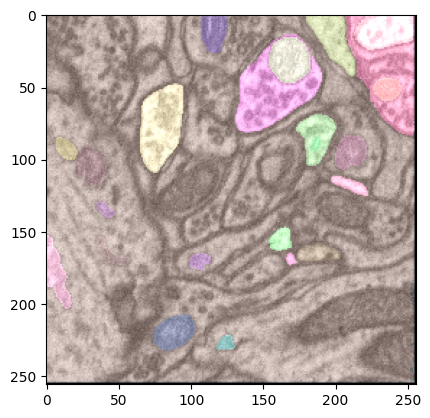

In [ ]:
imshow( mh.imread('first_output.png') )

In [ ]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER

#### I think that SAM worked well for detection but the output image we got above does not exactly replicate with the masks that we loaded before.

In [ ]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

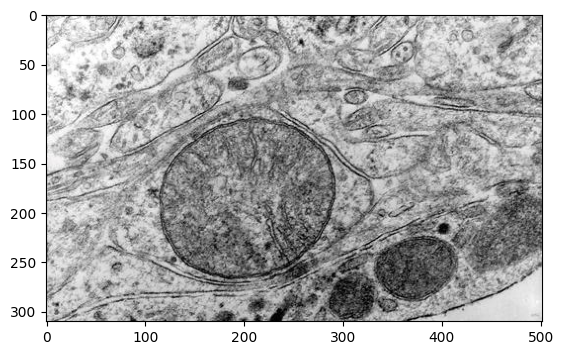

In [ ]:
img = plt.imread("img.png")
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# TODO: YOUR CODE
results = SegAutoMaskPredictor().image_predict(
    source="img.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)


vit_l model already exists as 'vit_l.pth'. Skipping download.


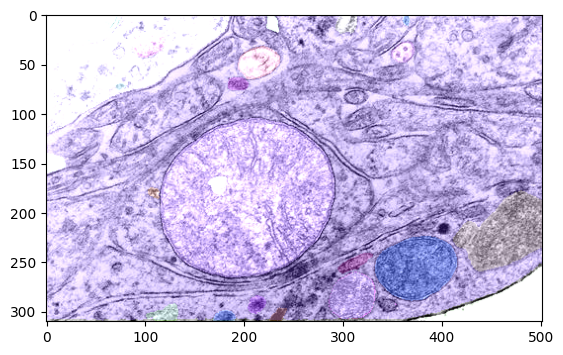

In [ ]:
imshow(mh.imread('second_output.png'))


In [ ]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

#### Yes, I think SAM worked better on my image too.

## 2. Train a U-Net classifier from scratch (50 points)


In [ ]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


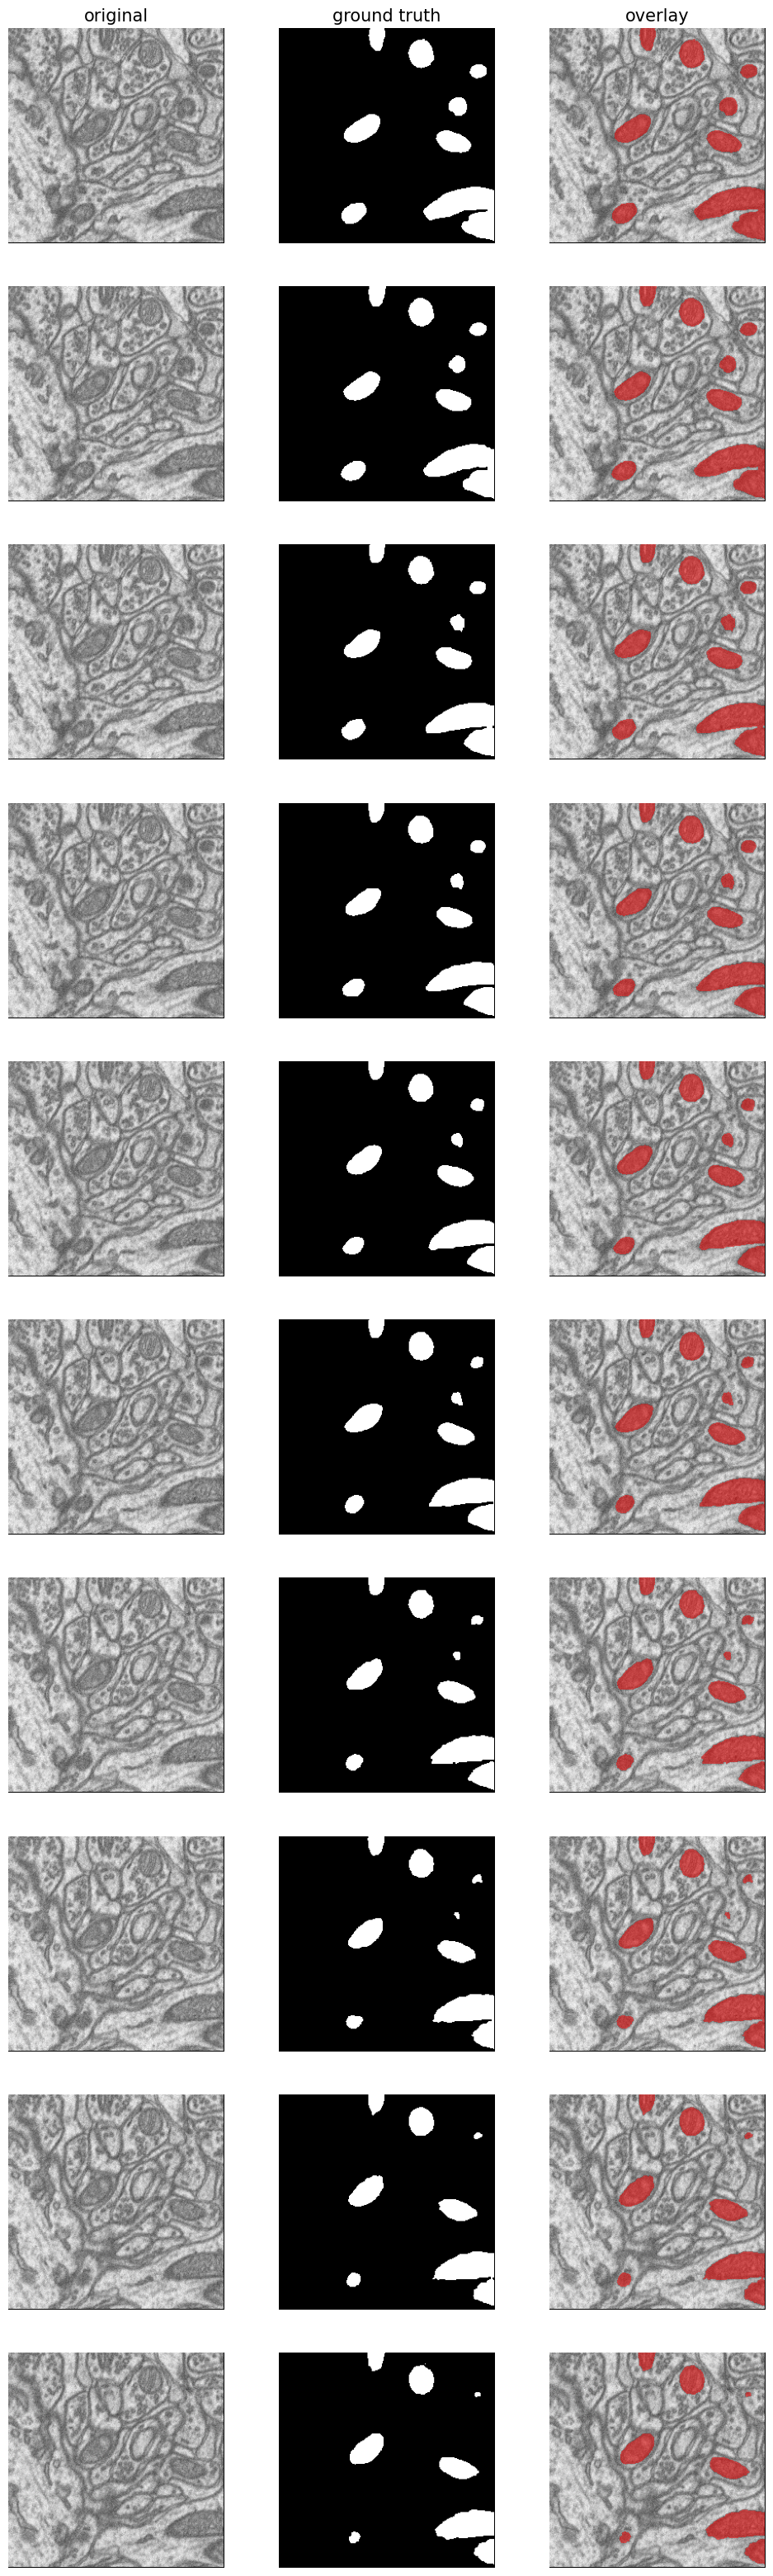

In [ ]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [ ]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 

X = images.astype('float32') / 243.0
X = X.reshape((660, 256, 256, 1))



In [ ]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [ ]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 

# Convert masks to bool
y = masks.astype(bool)

# Reshape the masks and add the last channel
y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))


In [ ]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [ ]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [ ]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

#### we call train_test_split again to operate on "X_train and y_train" (the train set that is obtained from the first split using train_test_split)
#### to further split the data into train dataset and validation dataset .
#### So in total we have 3 sets: train dataset, validation dataset and test dataset.

In [ ]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [ ]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

####The code is being used to set up a data generator for the training set with data augmentation using the get_augmented function from keras
####The arguments above  specify various types of data augmentation that will be applied to the input images during training like:
####rotation_range is for range of random rotation.
#### width_shift_range and height_shift_range is range of random horizontal and vertical shifts applied to images.
####shear_range and zoom_)range indicate range of random shearing and zooming that is applied to images.
####horizontal_flip and  vertical_flip are for flipping the image vertically or horizontally.
####fill_mode is used for filling in newly created pixels after applying given transformations to the image.

(2, 256, 256, 1) (2, 256, 256, 1)


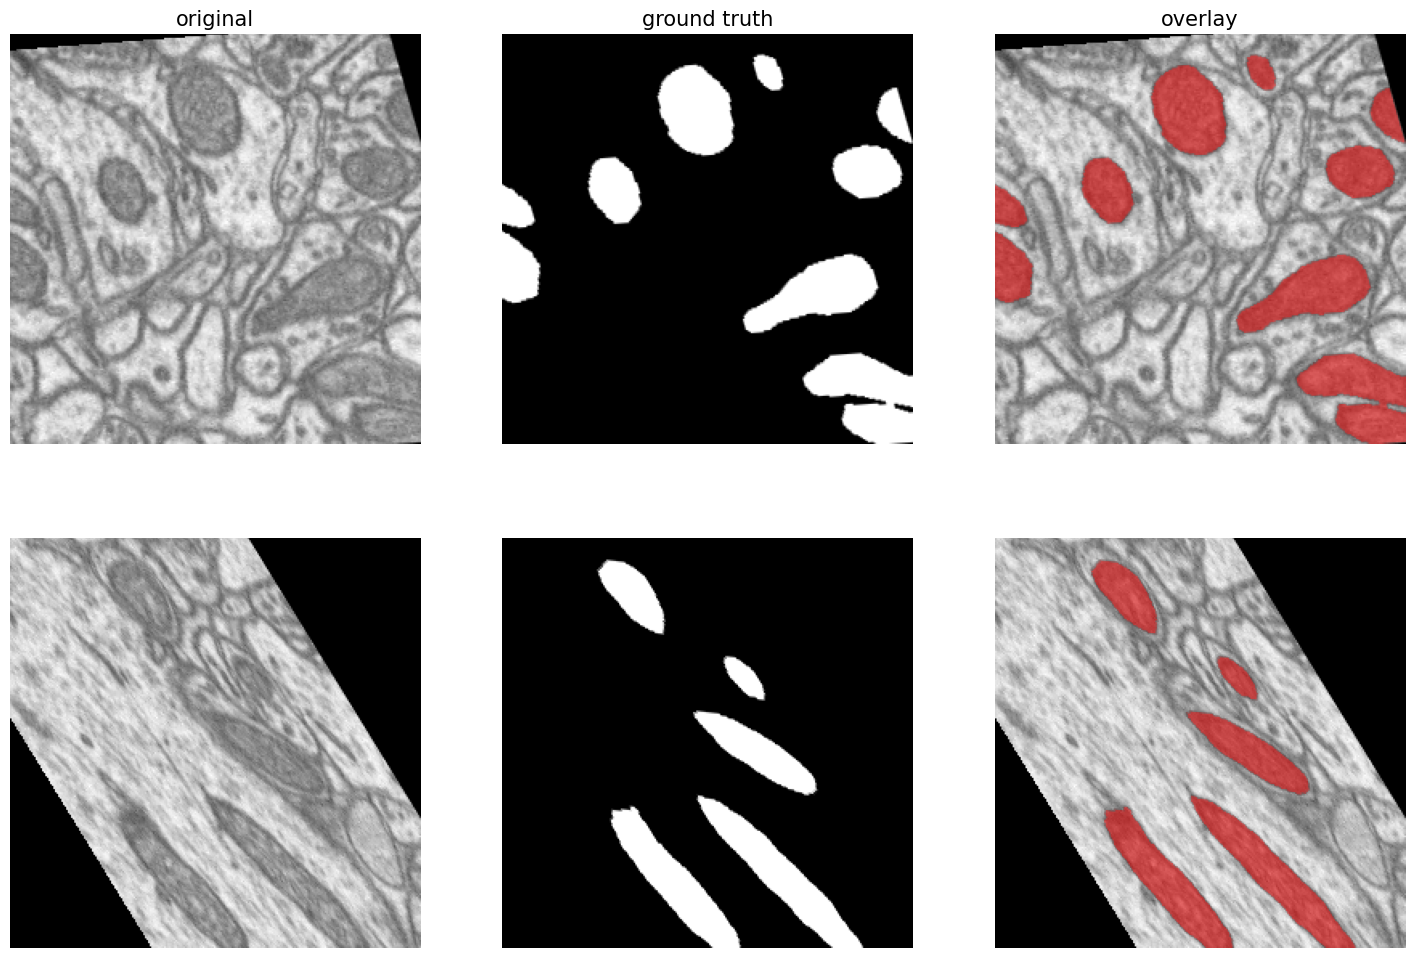

In [ ]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [ ]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [ ]:
# TODO: How many  trainable parameters does the model use?
# TODO: YOUR_ANSWER 

####Trainable parameters used: 31,030,593

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [ ]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [ ]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

####Iou metric tool is used to identify how well a computer vision model performs segmentation task.
####It calculates the overlap between the predicted segmentation mask and the ground truth mask. 
####A higher IoU value indicates  that it is  a more effective model.

In [ ]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#

history= model.fit(train_gen, epochs=30, steps_per_epoch= len(X_train),validation_data=(X_val, y_val))


Epoch 1/30
369/369 [==============================] - 103s 278ms/step - loss: 0.2079 - iou: 0.0824 - iou_thresholded: 0.0103 - val_loss: 0.1537 - val_iou: 0.2131 - val_iou_thresholded: 0.0711
Epoch 2/30
369/369 [==============================] - 60s 162ms/step - loss: 0.1652 - iou: 0.1531 - iou_thresholded: 0.1002 - val_loss: 0.1684 - val_iou: 0.1866 - val_iou_thresholded: 0.2267
Epoch 3/30
369/369 [==============================] - 59s 160ms/step - loss: 0.1610 - iou: 0.1793 - iou_thresholded: 0.1640 - val_loss: 0.1427 - val_iou: 0.2853 - val_iou_thresholded: 0.5073
Epoch 4/30
369/369 [==============================] - 59s 159ms/step - loss: 0.1349 - iou: 0.2384 - iou_thresholded: 0.2293 - val_loss: 0.1017 - val_iou: 0.4331 - val_iou_thresholded: 0.5845
Epoch 5/30
369/369 [==============================] - 59s 159ms/step - loss: 0.0879 - iou: 0.4379 - iou_thresholded: 0.5487 - val_loss: 0.0617 - val_iou: 0.5821 - val_iou_thresholded: 0.7399
Epoch 6/30
369/369 [========================

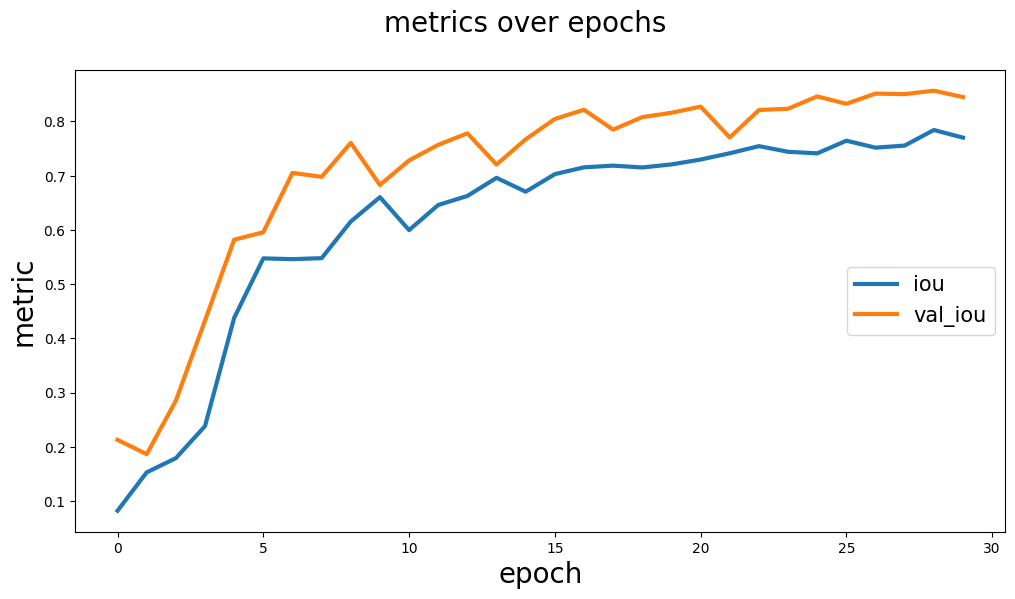

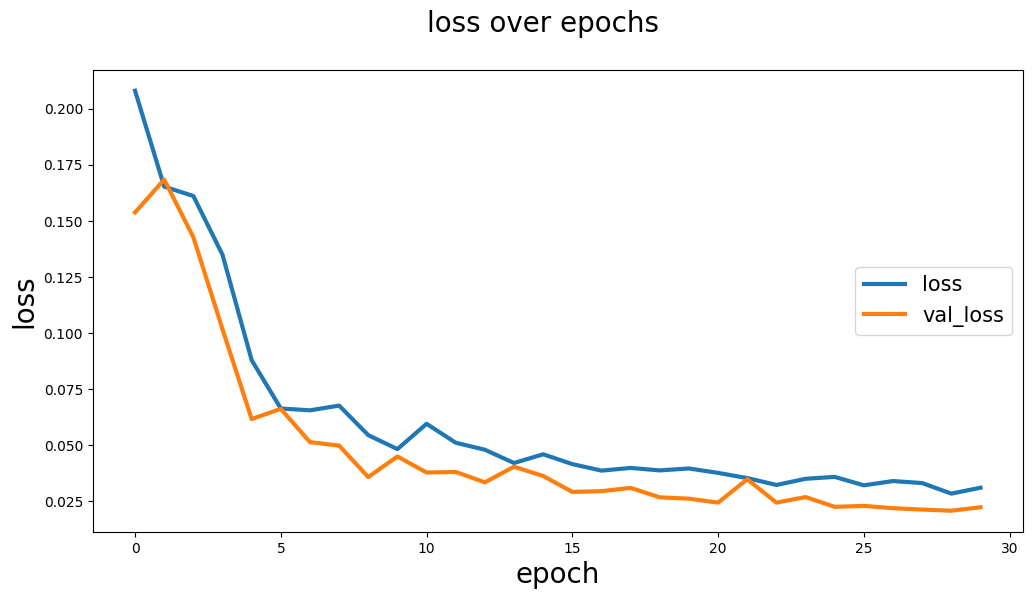

In [ ]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

####The training and validation accuracy plots tell us how  the model is classifying the training and validation data over time. 
####An increasing accuracy indicates that the model is improving its performance.
####the loss plots tell us how the model is learning to fit the training data and how well it generalizes to unseen validation data.
####A decreasing loss indicates that the model is improving its performance.
####But at some epoch points, the validation loss starts to increase while the training loss continues to decrease, this may indicate that the model is overfitting to the training data and not generalizing well to new data.

## 3. Evaluate U-Net (10 points)

In [ ]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 1s/step


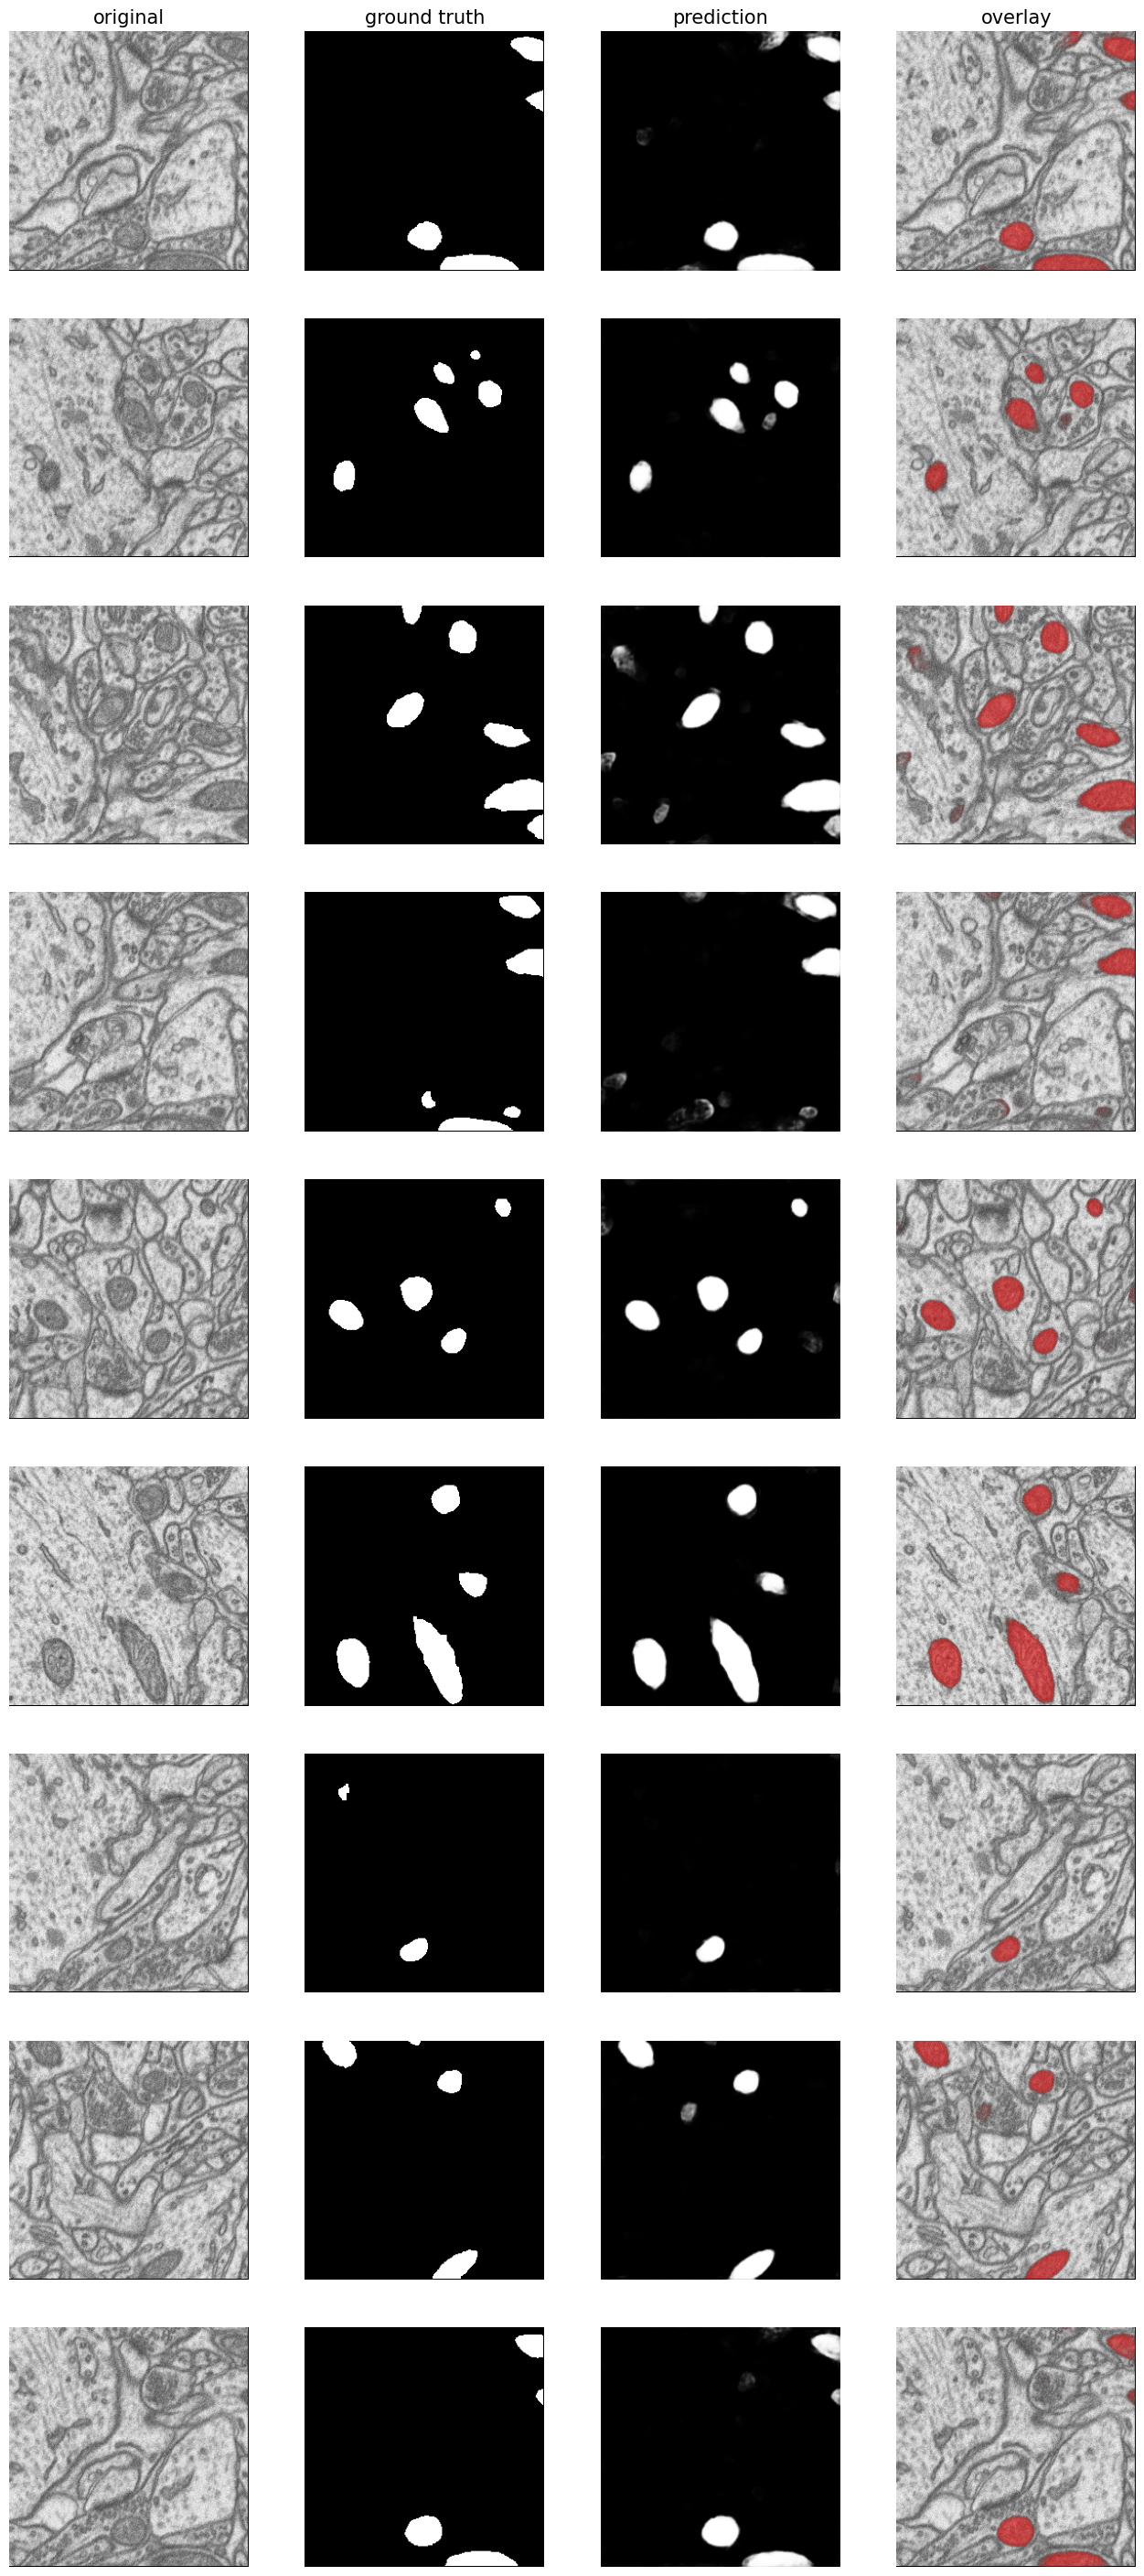

In [ ]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [ ]:
import sklearn.metrics

In [ ]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8917009613622353

In [ ]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

####Iou value was around 0.76(max) where as the Jaccard score is 0.89 . So the difference between them is  0.10(approx).
####Jaccard Score measures the similarity between two sets, where as  Intersect-over-Union (IoU) measures the amount of overlap between the predicted mask and the ground truth mask

In [ ]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

#### I think the U-Net model performed well on the X_test data.

## 4. Combine U-Net with SAM (10 points)

In [ ]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [ ]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [ ]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [ ]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [ ]:
from scipy.ndimage.interpolation import rotate
from scipy.ndimage import zoom



<ipython-input-60-d119d0de03d1>:1: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  ####saves the input image as a PNG file named "test.png". 
  ####It uses the first channel of the input image (img[:, :, 0]) and multiplies it by 255 to convert pixel values from [0,1] to [0,255] range.
  ####The resulting array is cast to np.uint8 data type.
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  ####applies a threshold of 0.5 to the U-Net prediction of the current image y_pred[z] to obtain a binary mask.
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
   ####labels the connected components in the binary mask obtained by using the "label" function.
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
   ####computes the bounding boxes of the connected components in the labeled image obtained by using the "bbox" function 
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
   ####converts the bounding boxes obtained above to the format accepted by the SAM model.
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  #### applies the SAM model to the input image "test.png" with the bounding boxes provided by bbs_converted in the above line. 
  ####It uses the SegManualMaskPredictor class  to obtain the predictions.
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
   ####converts the output of the SAM model to a binary mask

  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
   ####combines the U-Net prediction "y_pred[z]" with the output of the SAM model for the current "image sam_and_unet_pred" which we obtained above.
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [ ]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8917009613622353

In [ ]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8607846971609394

In [ ]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER
####On the basis of jaccard score, U-Net+SAM did not improve the performance of model, so this might not be a good addiion. But, the difference is very less.

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  pred = (y_pred[z] > 0.9)
 
  pred, _ = mh.labeled.label(pred)
  
  bbs = mh.labeled.bbox(pred)

  bbs_converted = mahotas_bbox_to_sam(bbs) 

  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  sam_and_unet_pred = sam_to_mask(results)
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

In [ ]:
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8701048445185956

In [ ]:
####As obtained above, if we increase the threshold value from 0.5 to 0.9 or greater, we can get a jaccard score value of 0.8701 which is greater than previous value(0.86)
####Hence, we can say that performance has been improved.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#